In [ ]:
from wordle_env import WordleEnv, WordleTokens
from stable_baselines3 import PPO
from gymnasium.wrappers import RecordEpisodeStatistics
from stable_baselines3.common.logger import configure
from datetime import datetime
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.monitor import Monitor          

log_dir = "runs/ppo"
new_logger = configure(folder=log_dir, format_strings=["stdout", "csv", "tensorboard"])


def make_env(seed=0):
    def _thunk():
        env = WordleEnv(calendar=None, eval_mode=False)
        env = Monitor(env)           # collects episode reward/length in `info`
        return env
    return _thunk

venv = DummyVecEnv([make_env()])     # 1-env vector (or more, if you like)
venv = VecMonitor(venv)     

model = PPO(
    "MlpPolicy", 
    env=venv, 
    tensorboard_log=log_dir,
    device='cuda', 
    verbose=1, 
    policy_kwargs=dict(
        features_extractor_class=WordleTokens,
        net_arch=[256,256]
    )
)

model.set_logger(new_logger)
model.learn(total_timesteps=200_000, tb_log_name=f"ppo_{datetime.now()}")

Logging to runs/ppo
Using cuda device


c:\Users\darcy\Documents\wordrl\venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
c:\Users\darcy\Documents\wordrl\venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.74     |
|    ep_rew_mean     | 0.633    |
| time/              |          |
|    fps             | 221      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.88        |
|    ep_rew_mean          | 0.541       |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.041966625 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.88       |
|    explained_variance   | -0.0107     |
|    learning_rate        | 0.

In [ ]:
eval_env = WordleEnv(target='admin', eval_mode=True)
obs, _ = eval_env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = eval_env.step(action)

In [ ]:
import string
symbols = { -1: "·", 0: "⬜", 1: "🟨", 2: "🟩" }
IDX2LETTER = {i: c for i, c in enumerate(string.ascii_uppercase)}
output = ""
for i in obs:
    word = ""
    tiles = ""
    for j in i:
        if j[1] == -1:
            break
        word += IDX2LETTER[j[0]]
        tiles += symbols[j[1]]
    output += f"{word} {tiles}\n" if tiles != "" else ""
print(output)

ADOBE 🟩🟩⬜⬜⬜
ADMIT 🟩🟩🟩🟩⬜
ADMIN 🟩🟩🟩🟩🟩



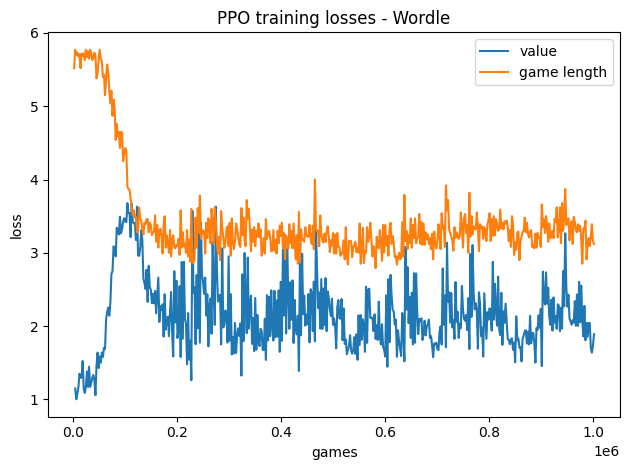

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("runs/ppo/progress.csv")

plt.plot(df["time/total_timesteps"], df["train/value_loss"],  label="value")
plt.plot(df["time/total_timesteps"], df['rollout/ep_len_mean'], label='game length')
plt.xlabel("games")
plt.ylabel("loss")
plt.legend()
plt.title("PPO training losses - Wordle")
plt.tight_layout()
plt.show()